In [1]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch import nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

2.2.1+cu121


In [2]:
df = pd.read_csv('../fyp_data/smooth_df.csv')

date_column = 'Date'
date_number_column = 'Date Number'
ili_rate_column = 'ILI Rate'
query_columns = [col for col in df.columns if col not in [date_column, date_number_column, ili_rate_column]]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [3]:
def custom_time_series_split(df, date_column):
    # Custom time series split based on years
    years = df[date_column].dt.year.unique()
    splits = [(years[5], years[i]) for i in range(10, len(years) - 4)]
    return splits

def get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date):
    # Get the training and test data for a specific split
    train_indices = (X_shifted[date_column] >= train_start_date) & (X_shifted[date_column] < test_start_date)
    test_indices = (X_shifted[date_column] >= test_start_date) & (X_shifted[date_column] <= test_end_date)
    corr_indices = (X[date_column] >= corr_start_date) & (X[date_column] < test_start_date)

    X_train, y_train = X_shifted[train_indices], y_shifted[train_indices]
    X_test, y_test = X_shifted[test_indices], y_shifted[test_indices]
    X_corr, y_corr = X[corr_indices], y[corr_indices]

    return (X_train.iloc[:, 1:], y_train, X_test.iloc[:, 1:], y_test, X_corr.iloc[:, 1:], y_corr)

def min_max_data(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train_scaled, X_test_scaled

def create_lagged_features(df, n_lags):
    lagged_dfs = [df]
    for lag in range(1, n_lags + 1):
        lagged_df = df.shift(lag)
        lagged_df = lagged_df.add_suffix(f'_t-{lag}')
        lagged_dfs.append(lagged_df)

    all_lagged_df = pd.concat(lagged_dfs, axis=1)
    all_lagged_df = all_lagged_df.dropna()
    return all_lagged_df

def create_lagged_features_with_overlap(X_train, y_train, X_test, n_lags=13):
    X_train_lagged = create_lagged_features(X_train, n_lags)
    y_train = y_train.iloc[n_lags:]

    X_test = pd.concat([X_train.iloc[-n_lags:], X_test], ignore_index=True)
    X_test_lagged = create_lagged_features(X_test, n_lags)

    return X_train_lagged.values, y_train, X_test_lagged.values

def convert_to_tensor(X_train, y_train, X_test, y_test):
    return (
        torch.FloatTensor(X_train), torch.FloatTensor(y_train.values), torch.FloatTensor(X_test), torch.FloatTensor(y_test.values)
    )

In [4]:
def get_correlation_df(X_corr, y_corr):
    correlation_scores = []
    for query_column in X_corr.columns:
        correlation = y_corr.corr(X_corr[query_column])
        correlation_scores.append((query_column, correlation))
    return pd.DataFrame(correlation_scores, columns=['Query', 'Correlation'])

def correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold):
    correlation_df = get_correlation_df(X_corr, y_corr).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    relevant_queries = correlation_df[correlation_df['Correlation'] >= threshold]['Query'].to_list()

    X_train = X_train[relevant_queries]
    X_test = X_test[relevant_queries]

    print("number of features after correlation based fs: ", X_train.shape[1])
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

    return X_train, X_test

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_ffnn(X_train, seed):
    torch.manual_seed(seed)
    return SimpleNN(X_train.shape[1]).to(device)

In [6]:
def train_neural_network(model, X_train, y_train, X_test, y_test, test_start_year, epochs=200, learning_rate=0.001, patience=15):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=14, shuffle=False)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=14, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))

        # Test phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(1)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)
            test_losses.append(test_loss)

    # plt.figure(figsize=(10, 6))
    # plt.plot(train_losses, label='Training Loss')
    # plt.plot(test_losses, label='Test Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
    # plt.legend()
    # plt.show()

    return (model, epoch+1, train_losses, test_losses)


def evaluate_neural_network(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_pred = model(X_test)


        y_pred_cpu = y_pred.cpu().detach().numpy().flatten()
        y_test_cpu = y_test.cpu().numpy().flatten()

        print("y_pred: ", y_pred_cpu[0:5])

        mae = mean_absolute_error(y_test_cpu, y_pred_cpu)
        mape = np.mean(np.abs((y_test_cpu - y_pred_cpu) / y_test_cpu)) * 100
        pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)
        print("MAE: ", mae, "MAPE: ", mape, "P: ", pearson_corr)

    return y_pred_cpu, mae, mape, pearson_corr

In [9]:
def add_average_row(model_performance):
    mae_avg = np.mean(model_performance['MAE'])
    pearson_corr_avg = np.mean(model_performance['Pearson_Correlation'])
    mape_avg = np.mean(model_performance['MAPE'])
    print("MAE AVG: ", mae_avg, "MAPE AVG: ", mape_avg, "P AVG: ", pearson_corr_avg, "\n\n")

    model_performance.loc[len(model_performance)] = {
        'Year': 'Average',
        'MAE': mae_avg,
        'MAPE': mape_avg,
        'Pearson_Correlation': pearson_corr_avg
    }

def run_neural_network(queries, threshold):
    X = df[[date_column] + queries]
    y = df[ili_rate_column]

    forecasting_horizon = 28
    y_shifted = y.shift(-forecasting_horizon)
    y_shifted = y_shifted.iloc[:-forecasting_horizon]
    X_shifted = X.iloc[:-forecasting_horizon]

    splits = custom_time_series_split(df, date_column)
    
    seed_train_losses = {}
    seed_test_losses = {}

    seed_performances = []
    seed_predictions = []

    seeds = [9904, 5727, 4644, 2955, 3021, 3094, 8349, 5566, 1564, 1723]

    for seed in seeds:
        print("SEED: ", seed)

        model_performance = pd.DataFrame(columns=['Year', 'MAE', 'MAPE', 'Pearson_Correlation'])
        model_predictions = pd.DataFrame(columns=['Date', 'Actual_ILI_Rate', 'Predicted_ILI_Rate'])

        for train_start_year, test_start_year in splits:
            if (test_start_year, test_start_year+1) not in seed_train_losses:
                seed_train_losses[(test_start_year, test_start_year+1)] = []
                seed_test_losses[(test_start_year, test_start_year+1)] = []

            train_start_date = f'{train_start_year}-09-01'
            test_start_date = f'{test_start_year}-09-01'
            test_end_date = f'{test_start_year+1}-08-31'
            corr_start_date = f'{test_start_year-5}-09-01'

            print("train_start_date: ", train_start_date, "test_start_date: ", test_start_date, "test_end_date: ", test_end_date)

            X_train, y_train, X_test, y_test, X_corr, y_corr = get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date)
            X_train, X_test = correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold)
            X_train, X_test = min_max_data(X_train, X_test)
            # X_train, y_train, X_test = create_lagged_features_with_overlap(X_train, y_train, X_test)
            X_train, y_train, X_test, y_test = convert_to_tensor(X_train.values, y_train, X_test.values, y_test)

            model, epochs, train_losses, test_losses = train_neural_network(create_ffnn(X_train, seed), X_train, y_train, X_test, y_test, test_start_year)
            seed_train_losses[(test_start_year, test_start_year+1)].append(train_losses)
            seed_test_losses[(test_start_year, test_start_year+1)].append(test_losses)
            y_pred, mae, mape, pearson_corr = evaluate_neural_network(model, X_test, y_test)

            model_performance.loc[len(model_performance)] = {
                'Year': f'{test_start_year}-{test_start_year+1}',
                'MAE': mae,
                'MAPE': mape,
                'Pearson_Correlation': pearson_corr,
            }

            date_range = pd.date_range(start=f'{test_start_year}-09-{forecasting_horizon+1}', periods=len(y_pred))
            iteration_predictions = pd.DataFrame({
                'Date': date_range,
                'Predicted_ILI_Rate': y_pred,
                'Actual_ILI_Rate': y_test.cpu().numpy().flatten()
            })
            model_predictions = pd.concat([model_predictions, iteration_predictions])

        add_average_row(model_performance)

        seed_performances.append(model_performance)
        seed_predictions.append(model_predictions)

    avg_performance = pd.concat(seed_performances).groupby(['Year']).agg({'MAE': ['mean', 'std'], 'Pearson_Correlation': ['mean', 'std'], 'MAPE': ['mean', 'std']}).reset_index().round(5)
    avg_predictions = pd.concat(seed_predictions).groupby(['Date']).mean().reset_index()

    for test_start_year, test_end_year in seed_train_losses.keys():
        mean_train_losses = np.mean(np.array(seed_train_losses[(test_start_year, test_end_year)]), axis=0)
        mean_test_losses = np.mean(np.array(seed_test_losses[(test_start_year, test_end_year)]), axis=0)

        plt.figure(figsize=(10, 6))
        plt.plot(mean_train_losses, label='Training Loss')
        plt.plot(mean_test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
        plt.legend()
        plt.show()

    return avg_performance, avg_predictions

SEED:  9904
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)


y_pred:  [3.0621564 3.4355655 2.649665  2.6831136 2.8410976]
MAE:  1.3058188 MAPE:  23.360349237918854 P:  0.9454428420827514
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.4830397 1.1245103 1.6298774 2.0172415 1.4733403]
MAE:  1.5532845 MAPE:  23.24809730052948 P:  0.9379967933593938
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.0493002 2.1725953 1.9443855 1.4837239 2.003754 ]
MAE:  2.5206 MAPE:  60.87081432342529 P:  0.9423826927318366
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.266155  1.4867859 2.556753  2.5290549 2.881362 ]
MAE:  2.5260155 MAPE:  30.76283633708954 P:  0.9844258431248883
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.604413  1.4609435 1.3952944 1.6867063 2.504231 ]
MAE:  2.352378 MAPE:  61.96765899658203 P:  0.9329931108832957
MAE AVG:  2.0516193 MAPE AVG:  40.04195123910904 P AVG:  0.9486482564364331 


SEED:  5727
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.8670757 3.5310721 2.4168956 2.4173155 2.6466858]
MAE:  1.3585385 MAPE:  25.314828753471375 P:  0.9423753590051239
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.3289891 1.0842777 1.5245517 1.8601428 1.3823344]
MAE:  1.5582682 MAPE:  22.41876721382141 P:  0.9407326790022287
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.1689572 2.2476938 1.9805084 1.8312769 2.2063355]
MAE:  2.2892363 MAPE:  48.83769750595093 P:  0.939362844505252
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.8747854 2.175564  2.4229689 2.582584  2.4413779]
MAE:  2.0539517 MAPE:  21.068064868450165 P:  0.9766700928039579
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [5.2662487 5.2662487 5.2662487 5.2662487 5.2662487]
MAE:  4.4170127 MAPE:  109.50992107391357 P:  nan
MAE AVG:  2.3354015 MAPE AVG:  45.42985588312149 P AVG:  0.9497852438291405 


SEED:  4644
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)


/tmp/ipykernel_870217/3281515322.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)


y_pred:  [2.8934712 3.3049874 2.6875925 2.602237  2.8882039]
MAE:  1.249747 MAPE:  19.897715747356415 P:  0.9446341097411484
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.9846354 1.9105258 2.2002392 2.280705  2.00986  ]
MAE:  1.4130028 MAPE:  17.096354067325592 P:  0.9458778716884652
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.3393877 2.2178094 2.0492542 1.9620144 2.475806 ]
MAE:  2.4479916 MAPE:  51.985931396484375 P:  0.9351972673996305
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.8303916 2.066117  2.5660477 2.5703707 2.59881  ]
MAE:  1.83465 MAPE:  20.43539434671402 P:  0.9841085731782268
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8548721 1.9106281 1.8057823 2.0762553 2.276585 ]
MAE:  1.1718472 MAPE:  23.357756435871124 P:  0.9590276517400013
MAE AVG:  1.6234478 MAPE AVG:  26.554630398750305 P AVG:  0.9537690947494945 


SEED:  2955
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [3.1256735 3.2799706 2.7234175 2.7104282 2.876413 ]
MAE:  1.2930118 MAPE:  22.460268437862396 P:  0.9463652916382376
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.1812017 1.0115297 1.4680203 1.7017843 1.3712913]
MAE:  1.5690137 MAPE:  21.648460626602173 P:  0.9420239158380643
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.2095678 2.3027651 2.0877783 1.930141  2.2732513]
MAE:  2.38187 MAPE:  49.76277947425842 P:  0.939912408462088
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.6501522 1.9740577 2.2873774 2.3506918 2.2811794]
MAE:  2.318084 MAPE:  24.568335711956024 P:  0.9826498896512701
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8073117 1.8687865 1.7859993 1.9705966 2.3791447]
MAE:  1.1554695 MAPE:  25.141271948814392 P:  0.9628294060568667
MAE AVG:  1.7434899 MAPE AVG:  28.71622323989868 P AVG:  0.9547561823293054 


SEED:  3021
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.792448  3.3668756 2.564569  2.5303693 2.8186622]
MAE:  1.301138 MAPE:  21.27821445465088 P:  0.9414690528070346
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.8116292 1.5208086 1.8974012 2.1062298 1.6909624]
MAE:  1.5093505 MAPE:  20.54525315761566 P:  0.9383311510322276
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [1.9490446 2.267439  1.8195635 0.9246234 1.7608443]
MAE:  2.5756614 MAPE:  65.10316729545593 P:  0.9401703190101166
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.6699893 1.952555  2.2948594 2.348324  2.3628612]
MAE:  2.1909368 MAPE:  21.68188989162445 P:  0.9819290126807066
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.9579338 1.8716451 1.830018  2.1733224 2.6959403]
MAE:  1.4672977 MAPE:  33.79148542881012 P:  0.958723224361675
MAE AVG:  1.808877 MAPE AVG:  32.48000204563141 P AVG:  0.9521245519783521 


SEED:  3094
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.9760876 3.6169267 2.5561113 2.5198188 2.7753413]
MAE:  1.3512152 MAPE:  24.979181587696075 P:  0.9421585718524745
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.4713627 1.1234952 1.6024917 1.9841446 1.423946 ]
MAE:  1.5530946 MAPE:  23.396509885787964 P:  0.9370133131559619
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [1.9311221  2.4000638  1.8501647  0.89710677 1.7107615 ]
MAE:  2.5892344 MAPE:  65.67537784576416 P:  0.9401900814683526
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.2107522 1.5499148 2.555064  2.522143  2.6980884]
MAE:  2.6427388 MAPE:  35.79497933387756 P:  0.9840310306204038
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8488969 1.4893817 1.3802457 2.0048146 2.6963573]
MAE:  2.1748693 MAPE:  55.637723207473755 P:  0.9402980858220408
MAE AVG:  2.0622306 MAPE AVG:  41.096754372119904 P AVG:  0.9487382165838467 


SEED:  8349
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.6930008 3.5475445 2.4727674 2.421298  2.7300906]
MAE:  1.3384894 MAPE:  23.457160592079163 P:  0.9407735959449937
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.8878055 1.581434  2.0167942 2.2044702 1.7481806]
MAE:  1.5073515 MAPE:  21.072237193584442 P:  0.9354019084891669
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [1.8760034 2.4608488 1.8483673 0.8904588 1.6916379]
MAE:  2.6388137 MAPE:  67.08118915557861 P:  0.9400955439594626
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.2513896 1.4971467 2.6087425 2.6033955 2.916877 ]
MAE:  2.5646403 MAPE:  33.334094285964966 P:  0.9842584880011266
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.7907608 1.8711107 1.8247418 2.0327246 2.2129042]
MAE:  1.1107627 MAPE:  22.87328988313675 P:  0.9585791280093066
MAE AVG:  1.8320115 MAPE AVG:  33.56359422206879 P AVG:  0.9518217328808113 


SEED:  5566
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [3.123592  3.2784038 2.6853166 2.6935773 2.851851 ]
MAE:  1.3009051 MAPE:  22.61786013841629 P:  0.9460942401494272
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.1736745 1.0319437 1.473015  1.6934882 1.3635345]
MAE:  1.5683079 MAPE:  21.677017211914062 P:  0.9424281014053361
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.2930088 2.2050073 2.0516465 2.0039454 2.4960706]
MAE:  2.2667644 MAPE:  46.906834840774536 P:  0.9357575029071827
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.6657103 1.8301535 2.5136151 2.46763   2.5954778]
MAE:  2.146673 MAPE:  23.51173460483551 P:  0.985944431564106
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8101717 1.2758837 1.1048651 1.8543456 2.5555072]
MAE:  1.9665862 MAPE:  46.411630511283875 P:  0.9400080581893948
MAE AVG:  1.8498474 MAPE AVG:  32.225015461444855 P AVG:  0.9500464668430894 


SEED:  1564
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.998333  3.5164585 2.567122  2.568037  2.804214 ]
MAE:  1.3328851 MAPE:  24.382106959819794 P:  0.9436236078010989
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.426484  1.0922269 1.5612882 1.8875061 1.3733443]
MAE:  1.556092 MAPE:  22.956018149852753 P:  0.9392466799333408
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.2025943 2.2875087 2.0581982 1.8731307 2.2484493]
MAE:  2.297112 MAPE:  49.23729598522186 P:  0.9407427674984191
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.8756708 2.1194284 2.4291341 2.4234576 2.3984802]
MAE:  2.1386168 MAPE:  20.064306259155273 P:  0.9785385310727436
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.8526652 1.4035466 1.2777424 1.9876616 2.6811683]
MAE:  2.0148578 MAPE:  49.134451150894165 P:  0.9406511832977742
MAE AVG:  1.8679127 MAPE AVG:  33.15483570098877 P AVG:  0.9485605539206752 


SEED:  1723
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [3.0284452 3.4159021 2.6290348 2.6493745 2.8191328]
MAE:  1.303873 MAPE:  23.373326659202576 P:  0.9457757396165596
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_870217/3537736535.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.316567  1.0464609 1.517544  1.8393968 1.3656434]
MAE:  1.5576689 MAPE:  22.546491026878357 P:  0.940339075699921
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [1.9043869 2.236096  1.7578042 0.9285431 1.762543 ]
MAE:  2.5530741 MAPE:  64.49834704399109 P:  0.9381173759998606
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.6760511 1.8236897 2.5684364 2.4505715 2.5722237]
MAE:  2.3060625 MAPE:  25.020742416381836 P:  0.9857920029481909
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.7868236 1.7895006 1.7952051 1.9501953 2.3580132]
MAE:  1.3493176 MAPE:  33.118027448654175 P:  0.9574181696442852
MAE AVG:  1.8139992 MAPE AVG:  33.711386919021606 P AVG:  0.9534884727817635 




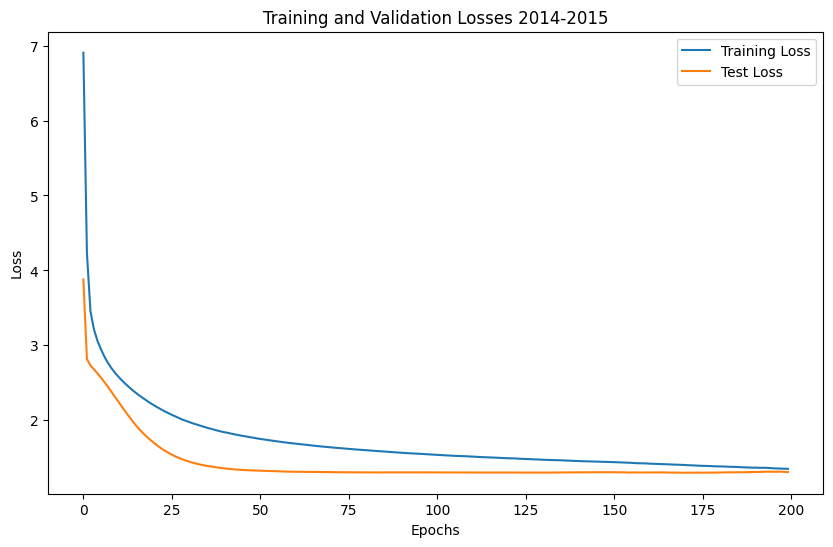

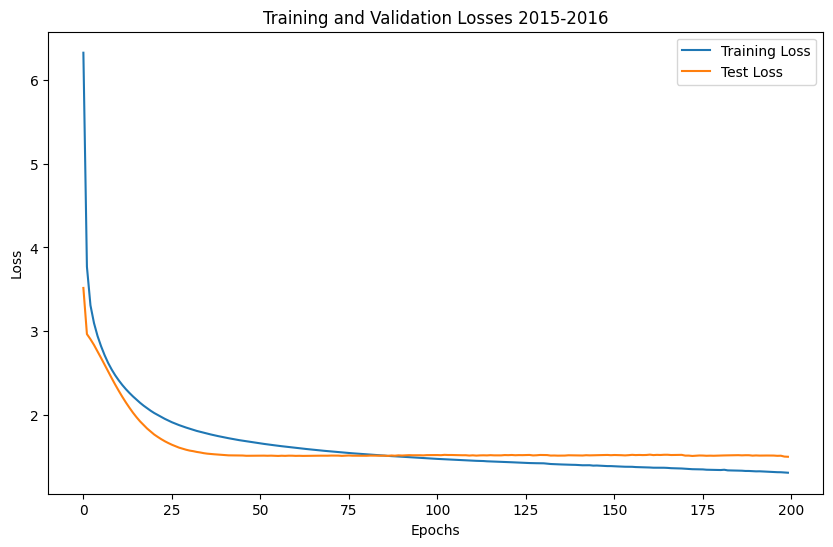

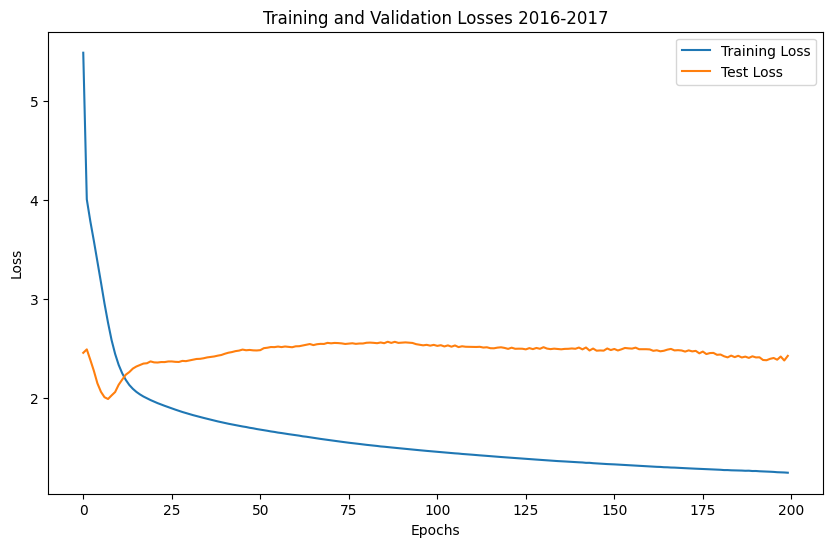

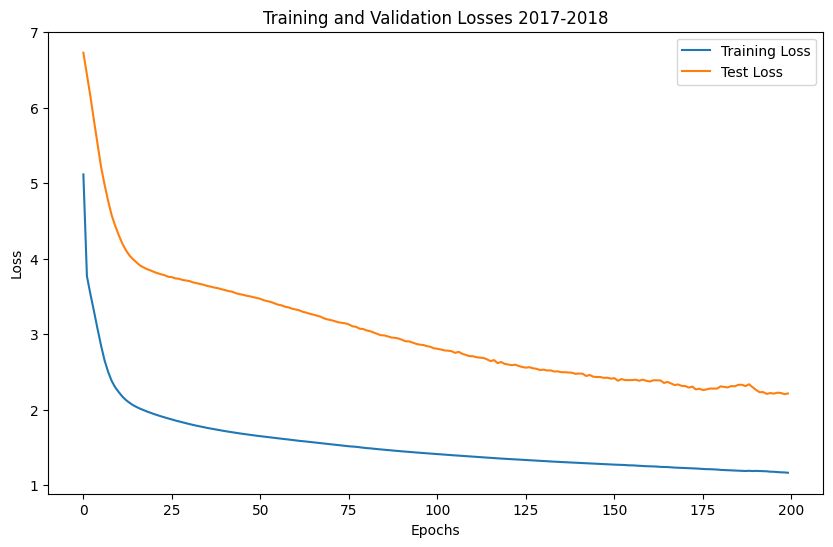

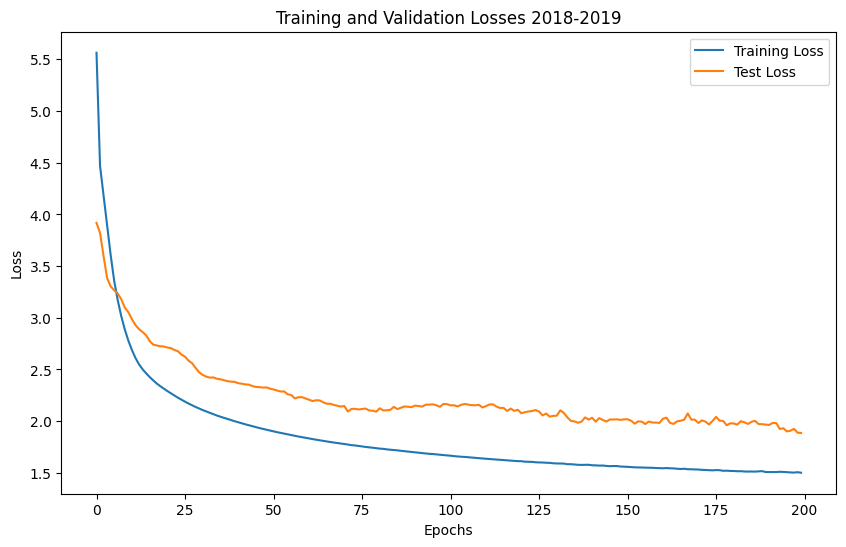

        Year      MAE          Pearson_Correlation               MAPE  \
                 mean      std                mean      std      mean   
0  2014-2015  1.31356  0.03232             0.94387  0.00207  23.11210   
1  2015-2016  1.53454  0.04800             0.93994  0.00303  21.66052   
2  2016-2017  2.45604  0.13885             0.93919  0.00223  56.99594   
3  2017-2018  2.27224  0.25161             0.98283  0.00304  25.62424   
4  2018-2019  1.91804  0.99039             0.95006  0.01130  46.09432   
5    Average  1.89888  0.20103             0.95117  0.00232  34.69742   

             
        std  
0   1.65208  
1   1.85575  
2   8.30017  
3   5.67030  
4  26.22311  
5   5.79701  


In [11]:
query_similarities = pd.read_csv('../fyp_data/average.csv').iloc[:1000]['Query'].to_list()
model_performance, model_predictions = run_neural_network(query_similarities, threshold=0.3)
model_performance.to_csv('../results/baseline_ffnn/forecasting_t+28_performance.csv', index=False)
model_predictions.to_csv('../results/baseline_ffnn/forecasting_t+28_predictions.csv', index=False)
print(model_performance)